In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [7]:
url = r"C:\Users\seksatta\Desktop\masterlist.xlsx"

In [8]:
df = pd.read_excel(url, skiprows=6, 
                  parse_dates=True)


In [9]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.lower().str.replace("\n","  ")
df.columns = df.columns.str.lower().str.replace(r' ','_')

In [10]:
df['error_code'] = df['problem'].str.extract(r'(\b[A-Z]\d{1})(?<!-)')


# Cleaning up date

อันนี้ดีเอาไว้ check ได้

In [11]:
df.rename(columns = {'parts__and_cover_page__received_date':'received_date'}, inplace = True)

In [12]:
def check_date_format(date_str):
    try:
        pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')
        return True
    except ValueError:
        return False

In [13]:
df['received_date'] = df['received_date'].apply(lambda x: np.nan if x == '-' else x)

In [14]:
invalid_dates = df[~df['received_date'].apply(check_date_format)]
print("Invalid dates:")
print(invalid_dates)

Invalid dates:
Empty DataFrame
Columns: [no., received_date, actual_received_parts, basic_investigate__received_date, plan_to_finished_basic_investigation_date, plan__send__date, actual___send__date, plan_of_analysis_start_date, doc._no., production_date, installation_date, problem_date, part_name, drawing, supplier_name, problem, model, serial, model_type, model_group, customer, urgent, normal, initial, spare_parts, concern__big_problem, gib_no, status, eqg, mkg, mkg_cover__reply_date_, due_date_for_supplier__(ref._std__lt), plan_of_submit_report_to_mkg, report, final_report, date_of_remain_for_analysis__(ref._std__lt), control_analysis_lt__(ref._std__lt), lt__usage_workday, diff_from_due_date_(workday), checking_result___from_supplier_ok/ng, cause, part_ng, remark, error_code]
Index: []

[0 rows x 44 columns]


 Change to str to datetime type

In [15]:
df['received_date'] = pd.to_datetime(df['received_date'] ,format = '%Y')

In [16]:
df['year'] = df['received_date'].dt.year
df['year'] = df['year'].fillna(0).astype(int)

In [17]:
df_pcb = df[df['part_name'].str.contains(r'\bPCB(?<!Thermistor)', case= False, regex=True)]
df_pcb.reset_index(inplace=True)


In [18]:
g = df_pcb.groupby('year')['mkg'].count()

Text(0, 0.5, 'qty of failure [pcs]')

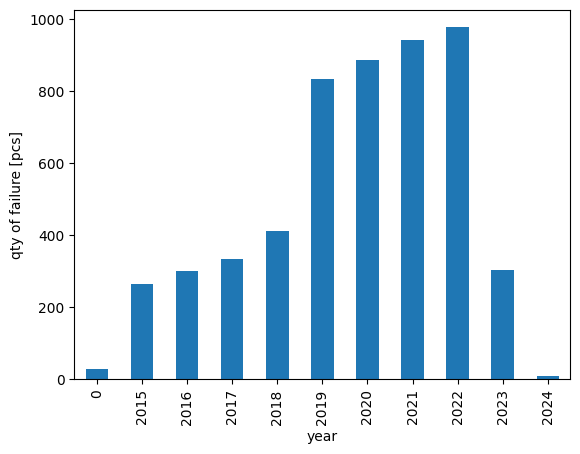

In [19]:
g.plot(kind='bar');
plt.ylabel("qty of failure [pcs]")

In [20]:
g1 = df_pcb.groupby(['year','error_code'])['mkg'].count().reset_index()

In [21]:
def get_top_5(group):
    return group.nlargest(5, 'mkg')


In [22]:
top_5_each_year = g1.groupby('year').apply(get_top_5).reset_index(drop=True)


C:\Users\seksatta\AppData\Local\Temp\ipykernel_21328\3711007168.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_each_year = g1.groupby('year').apply(get_top_5).reset_index(drop=True)


In [23]:
pivot_df = top_5_each_year.pivot(index='year', columns='error_code', values='mkg').fillna(0)


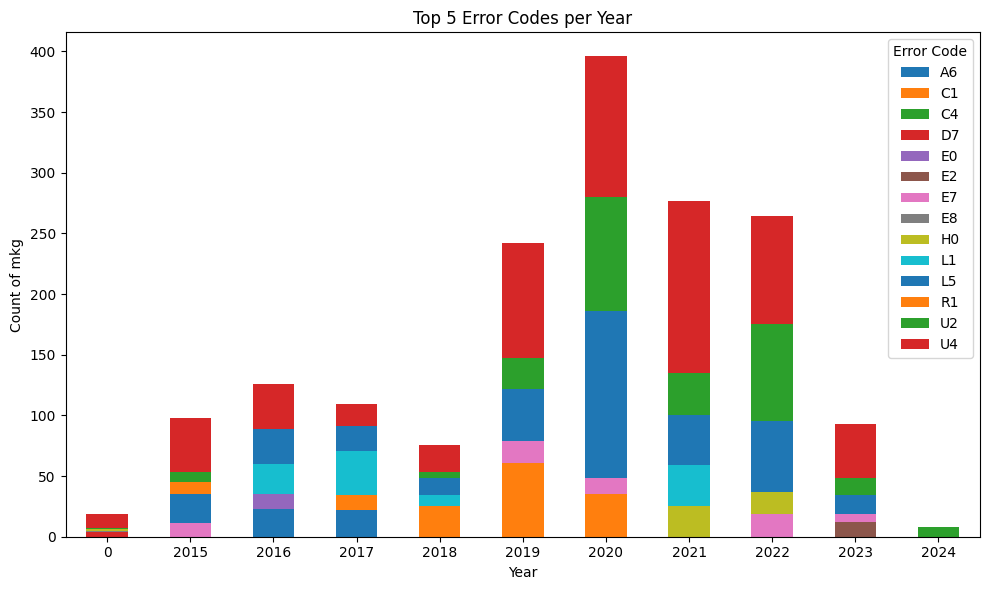

In [24]:
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Count of mkg')
plt.title('Top 5 Error Codes per Year')
plt.legend(title='Error Code')
plt.xticks(rotation=0)
plt.tight_layout()

In [25]:
try:
    # Replace 'model_dit.db' with the correct path to your database file
    with sqlite3.connect('model_dit.db') as conn:
        # SQL command to select all data from the dit_model table
        sql_comd = "SELECT * FROM dit_model"
        
        # Execute the SQL command and read the data into a pandas DataFrame
        df3 = pd.read_sql_query(sql_comd, conn)
        
        # Display the first few rows of the DataFrame
       

except Exception as e:
    print(f"An error occurred: {e}")

## Left join between df_pcb and df3 

In [28]:
df3.sample(10)

,model_name,base_model,group
10533,CTKM25PV14,BMS,RA
10544,FXFQ50AV4,SENSING_FLOW,VRV
11586,FXDQ18MVJU,VRV_SLIMDUCT,VRV
8851,RXQ6TAYME,VRV4-VRT,VRV
6042,ARKH35CAVMB,GMS5,RA
4242,AN45FV1,,
9601,FTXS18WVJU9,NW-M III,RA
3297,TWK524GBAA0,,
10025,RZR125MYM,ZEAS7,SKY
10211,3MKS71ESG,GBM,RA


In [35]:
df3.rename(columns = {'model_name':'model'}, inplace=True)

In [38]:
df_pcb = df_pcb.merge(df3, on='model', how='left')

0        True
1        True
2        True
3        True
4        True
        ...  
5289    False
5290    False
5291    False
5292    False
5293    False
Name: base_model, Length: 5294, dtype: bool